# 1. Import Necessary Libraries:

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

# 2. Import Dataset:

In [2]:
fraud_data = pd.read_csv('Fraud.csv')

In [3]:
fraud_data.loc[14246,]

step                        8
type                 CASH_OUT
amount               71154.12
nameOrig          C1072341683
oldbalanceOrg             0.0
newbalanceOrig            0.0
nameDest          C2036926986
oldbalanceDest      154929.17
newbalanceDest        45538.4
isFraud                     0
isFlaggedFraud              0
Name: 14246, dtype: object

In [4]:
fraud_data.shape

(6362620, 11)

In [5]:
pd.set_option('display.max_columns',None)
fraud_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


### Data Dictionary:

In [6]:
data_dict = open('Data Dictionary.txt','r')
print(data_dict.read())

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to anot

# 3. Data Understanding:

## 3.1: Initial Analysis:

In [7]:
fraud_data.shape

(6362620, 11)

In [8]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
fraud_data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
fraud_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [11]:
fraud_data.describe(include='object')

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


### 3.2. Converting categorical feature to numerical feature:

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [12]:
fraud_data_1 = fraud_data.copy()

In [13]:
fraud_data_1['type'] = le.fit_transform(fraud_data_1['type'])
fraud_data_1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,4,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,1,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,4,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


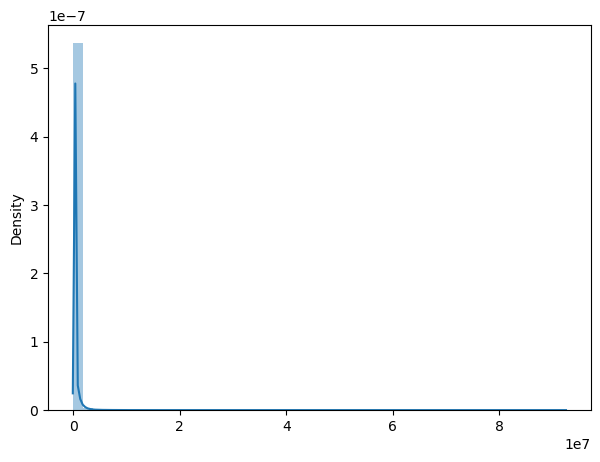

In [16]:
plt.figure(figsize=(7,5))
sns.distplot(x = fraud_data_1.amount)
plt.show()

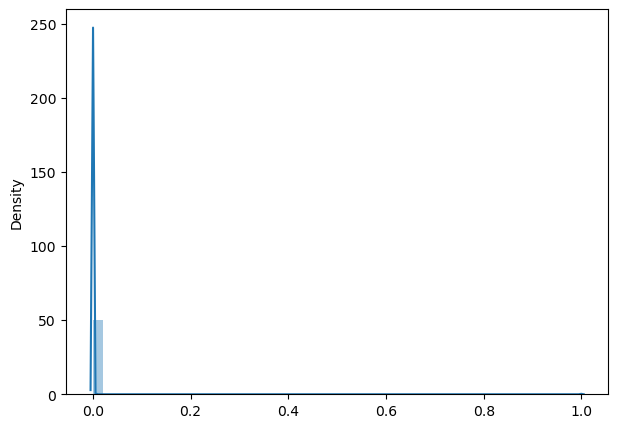

In [17]:
plt.figure(figsize=(7,5))
sns.distplot(x = fraud_data_1.isFraud)
plt.show()

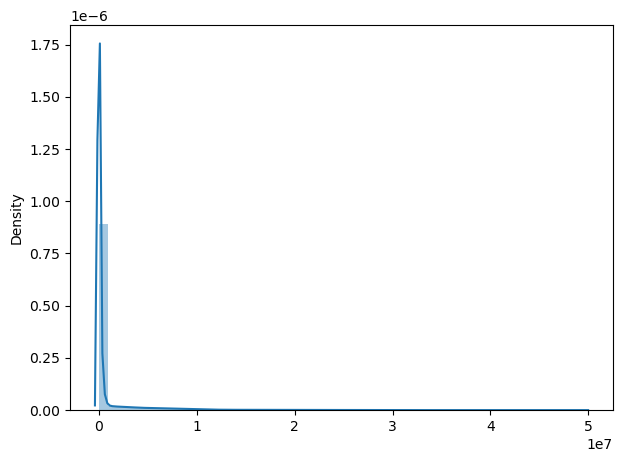

In [18]:
plt.figure(figsize=(7,5))
sns.distplot(x = fraud_data_1.newbalanceOrig)
plt.show()

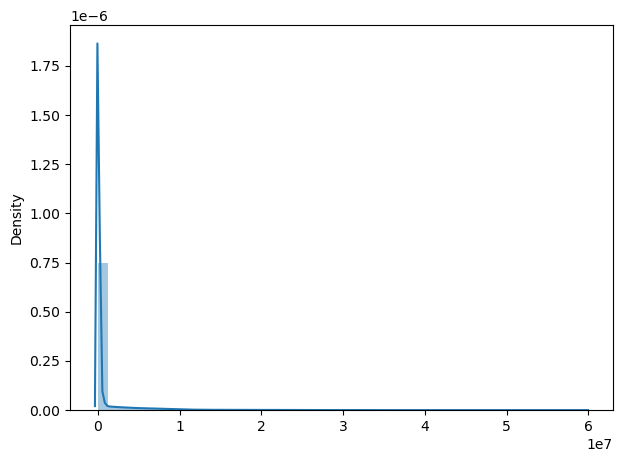

In [19]:
plt.figure(figsize=(7,5))
sns.distplot(x = fraud_data_1.oldbalanceOrg)
plt.show()

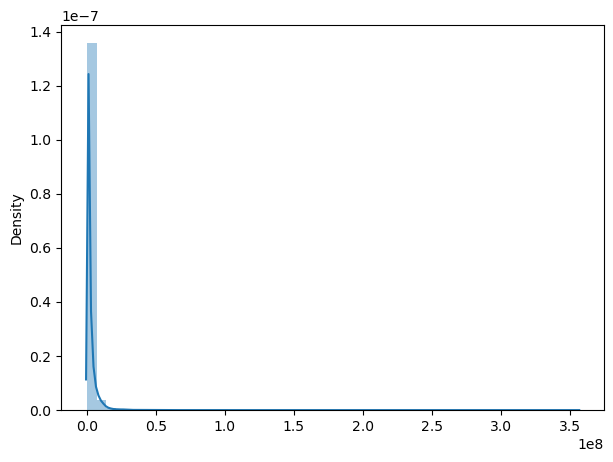

In [20]:
plt.figure(figsize=(7,5))
sns.distplot(x = fraud_data_1.newbalanceDest)
plt.show()

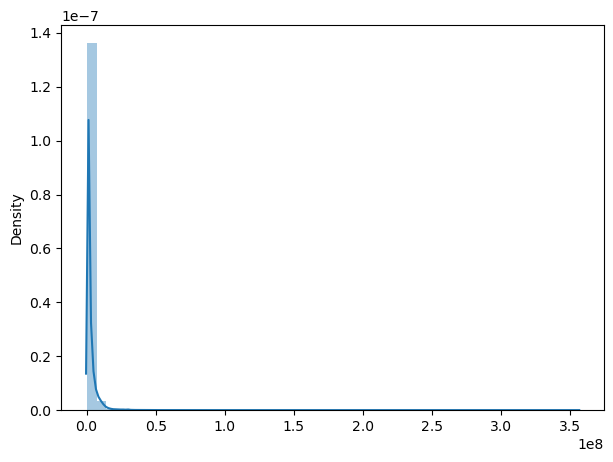

In [21]:
plt.figure(figsize=(7,5))
sns.distplot(x = fraud_data_1.oldbalanceDest)
plt.show()

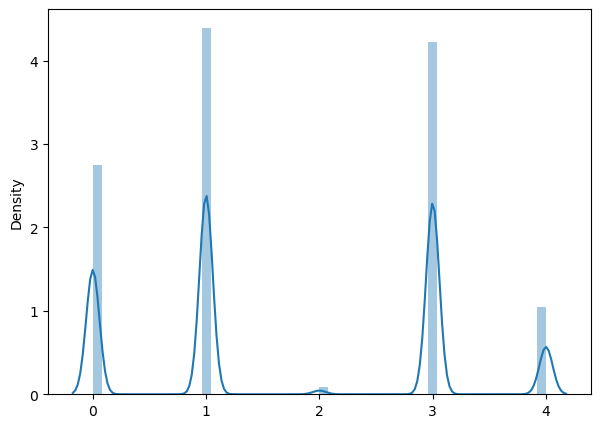

In [22]:
plt.figure(figsize=(7,5))
sns.distplot(x = fraud_data_1.type)
plt.show()

### 3.3. Understanding the relationship between features:
(Whether the relationship is linear or non-linear)

In [29]:
pps_mat = pps.matrix(fraud_data_1)
pd.set_option('display.max_rows', None)
pps_mat

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,step,step,1.000000,predict_itself,True,None,0.000000e+00,1.000000e+00,None
1,step,type,0.000000,regression,True,mean absolute error,1.160000e+00,1.249433e+00,DecisionTreeRegressor()
2,step,amount,0.000000,regression,True,mean absolute error,1.621961e+05,1.993765e+05,DecisionTreeRegressor()
3,step,nameOrig,0.000000,target_is_id,True,None,0.000000e+00,0.000000e+00,None
4,step,oldbalanceOrg,0.000000,regression,True,mean absolute error,8.319641e+05,1.378153e+06,DecisionTreeRegressor()
5,step,newbalanceOrig,0.000000,regression,True,mean absolute error,8.520088e+05,1.406065e+06,DecisionTreeRegressor()
6,step,nameDest,0.000000,unknown_error,False,None,0.000000e+00,0.000000e+00,None
7,step,oldbalanceDest,0.000000,regression,True,mean absolute error,1.066222e+06,1.450267e+06,DecisionTreeRegressor()
8,step,newbalanceDest,0.000000,regression,True,mean absolute error,1.178044e+06,1.567601e+06,DecisionTreeRegressor()
9,step,isFraud,0.000000,regression,True,mean absolute error,2.000000e-03,3.230279e-03,DecisionTreeRegressor()


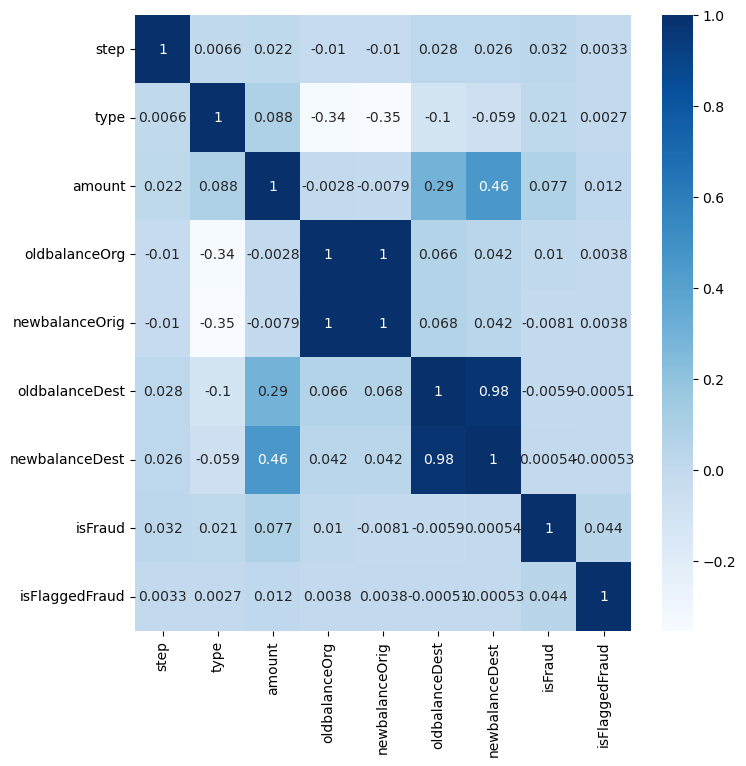

In [30]:
plt.figure(figsize=(8,8))
sns.heatmap(data = fraud_data_1.corr(), cmap='Blues', annot=True)
plt.show()

##### Observation:

1. type predicts amount with a predictive power score of 0.165654, and vice versa is true with pps of 0.345105.
2. There exists a multi-linear relationship between oldbalanceOrg and newbalanceOrig with a pps of 0.91.
Hence, we can choose to remove either of the features.
3. newbalanceOrig predicts type of transaction with a pps of 0.313985.
4. There exists a multi-linear relationship between newbalanceDest and oldbalanceDest with a pps of 0.73 approx.
Hence, we can choose to remove either of the features.
5. newbalanceDest predicts the type of transaction with a pps of 0.4. 

Text(0.5, 1.0, 'Total initial amount by fraud')

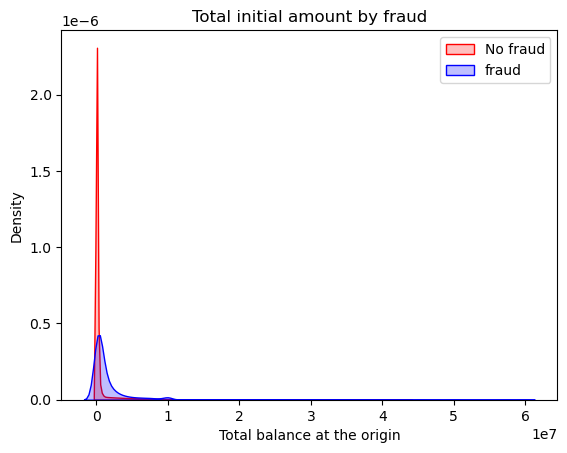

In [31]:
sns.kdeplot(fraud_data_1.oldbalanceOrg[(fraud_data_1.isFraud == 0) ],color="Red", shade = True)
sns.kdeplot(fraud_data_1.oldbalanceOrg[(fraud_data_1.isFraud == 1) ], color="Blue", shade= True)
plt.legend(["No fraud","fraud"],loc='upper right')
plt.ylabel('Density')
plt.xlabel('Total balance at the origin')
plt.title('Total initial amount by fraud')

Text(0.5, 1.0, 'Total final amount by fraud')

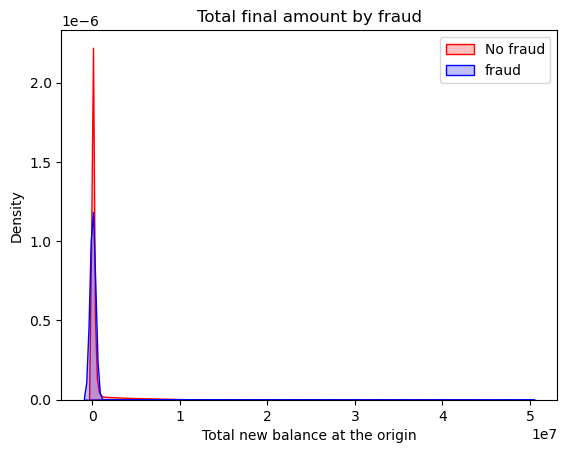

In [32]:
sns.kdeplot(fraud_data_1.newbalanceOrig[(fraud_data_1.isFraud == 0) ],color="Red", shade = True)
sns.kdeplot(fraud_data_1.newbalanceOrig[(fraud_data_1.isFraud == 1) ], color="Blue", shade= True)
plt.legend(["No fraud","fraud"],loc='upper right')
plt.ylabel('Density')
plt.xlabel('Total new balance at the origin')
plt.title('Total final amount by fraud')

Text(0.5, 1.0, 'Total initial amount(Destination) by fraud')

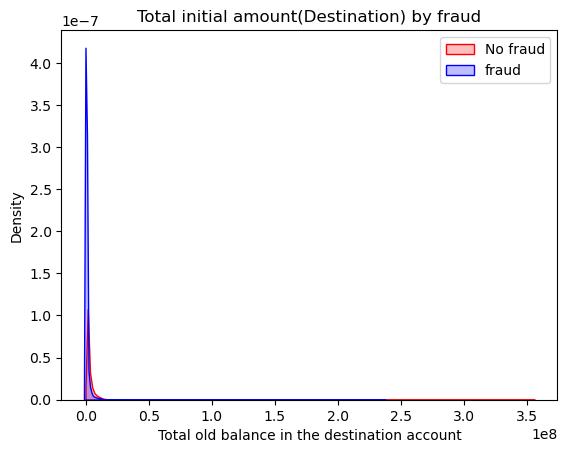

In [33]:
sns.kdeplot(fraud_data_1.oldbalanceDest[(fraud_data_1.isFraud == 0) ],color="Red", shade = True)
sns.kdeplot(fraud_data_1.oldbalanceDest[(fraud_data_1.isFraud == 1) ], color="Blue", shade= True)
plt.legend(["No fraud","fraud"],loc='upper right')
plt.ylabel('Density')
plt.xlabel('Total old balance in the destination account')
plt.title('Total initial amount(Destination) by fraud')

Text(0.5, 1.0, 'Total final amount in destination account by fraud')

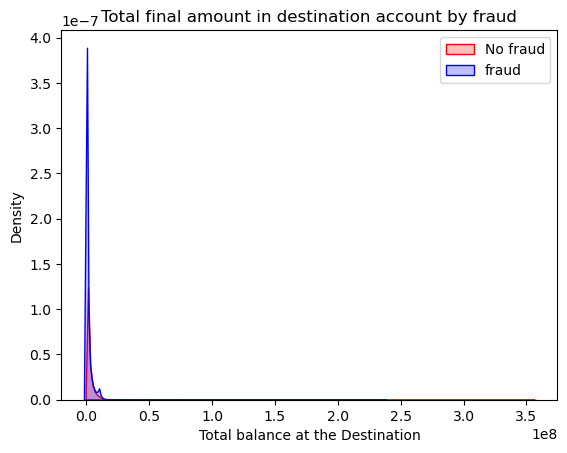

In [34]:
sns.kdeplot(fraud_data_1.newbalanceDest[(fraud_data_1.isFraud == 0) ],color="Red", shade = True)
sns.kdeplot(fraud_data_1.newbalanceDest[(fraud_data_1.isFraud == 1) ], color="Blue", shade= True)
plt.legend(["No fraud","fraud"],loc='upper right')
plt.ylabel('Density')
plt.xlabel('Total balance at the Destination')
plt.title('Total final amount in destination account by fraud')

Text(0.5, 1.0, 'Total amount by fraud')

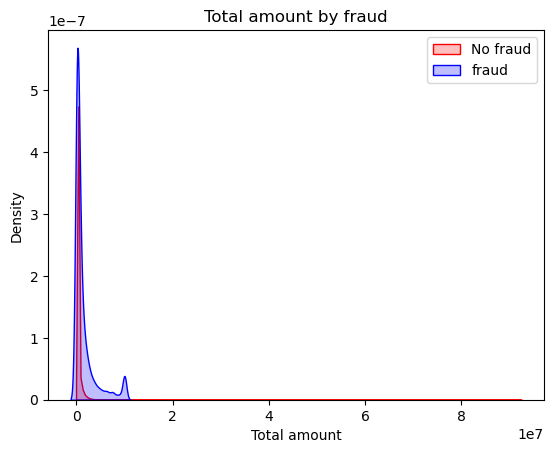

In [35]:
sns.kdeplot(fraud_data_1.amount[(fraud_data_1.isFraud == 0) ],color="Red", shade = True)
sns.kdeplot(fraud_data_1.amount[(fraud_data_1.isFraud == 1) ], color="Blue", shade= True)
plt.legend(["No fraud","fraud"],loc='upper right')
plt.ylabel('Density')
plt.xlabel('Total amount')
plt.title('Total amount by fraud')

##### Observation:
**Density of amount by fraud tranasction is greater than the density amount by non-fraud transactions.**

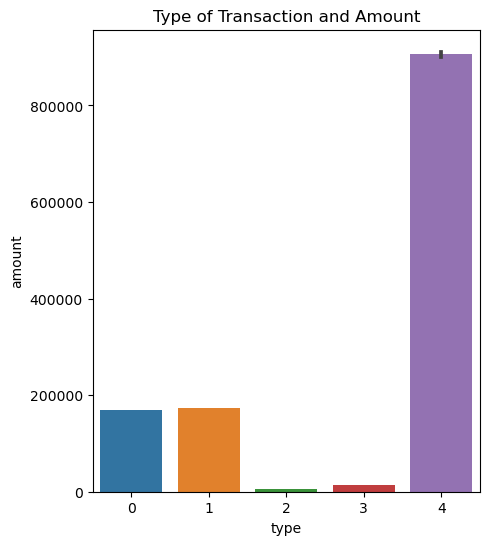

In [36]:
plt.figure(figsize=(5,6))
sns.barplot(data = fraud_data_1[fraud_data_1.isFraud==0], x='type', y='amount')
plt.title('Type of Transaction and Amount')
plt.show()

<AxesSubplot:xlabel='type', ylabel='amount'>

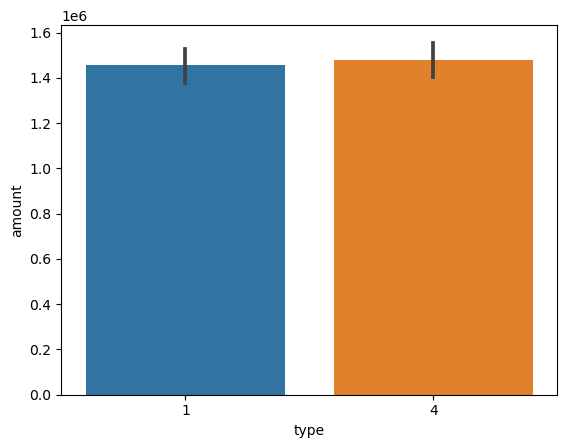

In [37]:
sns.barplot(data = fraud_data_1[fraud_data_1.isFraud==1], x='type', y='amount')

### 3.4. Frequency of values in features :

In [14]:
fraud_data_1.type.value_counts(sort = True)

1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: type, dtype: int64

In [15]:
len(fraud_data_1[fraud_data_1.isFraud==1].newbalanceOrig.value_counts())/len(fraud_data_1[fraud_data_1.isFraud==1].newbalanceOrig)

0.017654937294533057

In [16]:
len(fraud_data_1[fraud_data_1.isFraud==1].newbalanceDest.value_counts())/len(fraud_data_1[fraud_data_1.isFraud==1].newbalanceDest)

0.49519055156459274

In [17]:
# This shows how highly imbalaced the dataset is.

In [18]:
fraud_data_1.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [19]:
100*fraud_data_1['isFraud'].value_counts()/len(fraud_data_1['isFraud'])

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

##### Observation:
**The target variable is biased i.e., there is an imbalance in the dataset which can be balanced by oversampling the lower number of output (1 here).**

In [20]:
100*fraud_data_1[fraud_data_1.isFraud==1].type.value_counts()/len(fraud_data_1[fraud_data_1.isFraud==1].type)

1    50.11567
4    49.88433
Name: type, dtype: float64

##### Observation:
**The fradulent transactions occur only when the type of transaction is CASH_OUT and TRANSFER.**

In [21]:
100*fraud_data_1[fraud_data_1.isFraud==1].isFlaggedFraud.value_counts()/len(fraud_data_1[fraud_data_1.isFraud==1].isFlaggedFraud)

0    99.805187
1     0.194813
Name: isFlaggedFraud, dtype: float64

In [22]:
fraud_data_1.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [23]:
fraud_data_1['AmtChangeOri'] = (fraud_data_1.oldbalanceOrg - fraud_data_1.newbalanceOrig).values
fraud_data_1['AmtChangeDest'] = (fraud_data_1.newbalanceDest - fraud_data_1.oldbalanceDest).values

In [24]:
fraud_data_1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,AmtChangeOri,AmtChangeDest
0,1,3,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,3,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,1,3,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


## 3.5. Scenarios when fraud is possible:

### 1. when all the new balance in origin account is zero and change in balance at origin account is same as amount.

In [25]:
fraud_data_1['PossibleFraud_1'] = 0
frd = fraud_data_1.newbalanceOrig == 0 & (fraud_data_1.AmtChangeOri == fraud_data_1.amount)
fraud_data_1.loc[frd, 'PossibleFraud_1'] = 1
fraud_data_1[fraud_data_1.PossibleFraud_1 == 1].head(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,AmtChangeOri,AmtChangeDest,PossibleFraud_1
2,1,4,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0,181.00,0.00,1
3,1,1,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0,181.00,-21182.00,1
8,1,3,4024.36,C1265012928,2671.00,0.0,M1176932104,0.0,0.00,0,0,2671.00,0.00,1
10,1,2,9644.94,C1900366749,4465.00,0.0,C997608398,10845.0,157982.12,0,0,4465.00,147137.12,1
13,1,3,11633.76,C1716932897,10127.00,0.0,M801569151,0.0,0.00,0,0,10127.00,0.00,1
15,1,1,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0,15325.00,46430.44,1
16,1,3,1563.82,C761750706,450.00,0.0,M1731217984,0.0,0.00,0,0,450.00,0.00,1
19,1,4,215310.30,C1670993182,705.00,0.0,C1100439041,22425.0,0.00,0,0,705.00,-22425.00,1
24,1,4,311685.89,C1984094095,10835.00,0.0,C932583850,6267.0,2719172.89,0,0,10835.00,2712905.89,1
25,1,3,6061.13,C1043358826,443.00,0.0,M1558079303,0.0,0.00,0,0,443.00,0.00,1


<AxesSubplot:xlabel='type', ylabel='amount'>

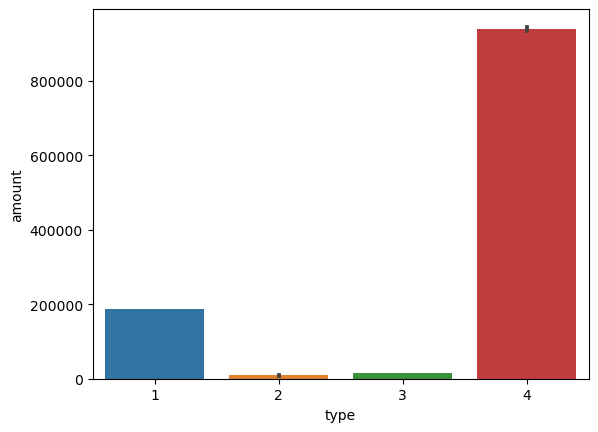

In [51]:
sns.barplot(data = fraud_data_1[fraud_data_1.PossibleFraud_1==1], x='type', y='amount')

### 2.  When Change in amount at destination account is not equal to amount:

In [26]:
fraud_data_1['PossibleFraud_2'] = 0
frd_1 = (fraud_data_1.AmtChangeDest == 0) & (fraud_data_1.amount>0)
frd_2 = frd_1 & (fraud_data_1.AmtChangeDest != fraud_data_1.amount) & (fraud_data_1.PossibleFraud_1 == 0) & (fraud_data_1.isFlaggedFraud == 0)
fraud_data_1.loc[frd_2, 'PossibleFraud_2'] = 1
fraud_data_1.head(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,AmtChangeOri,AmtChangeDest,PossibleFraud_1,PossibleFraud_2
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,9839.64,0.00,0,1
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,1864.28,0.00,0,1
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,181.00,0.00,1,0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,181.00,-21182.00,1,0
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,11668.14,0.00,0,1
5,1,3,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,7817.71,0.00,0,1
6,1,3,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,7107.77,0.00,0,1
7,1,3,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,7861.64,0.00,0,1
8,1,3,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,2671.00,0.00,1,0
9,1,2,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,5337.77,-1549.21,0,0


<AxesSubplot:xlabel='type', ylabel='amount'>

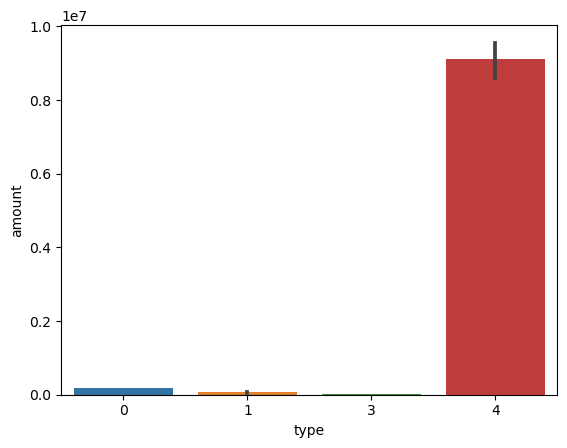

In [54]:
sns.barplot(data = fraud_data_1[fraud_data_1.PossibleFraud_2 == 1], x = 'type', y = 'amount')

# 4. Feature Engineering:

### 4.1. Dropping unwanted columns:

In [27]:
fraud_data_1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'AmtChangeOri', 'AmtChangeDest', 'PossibleFraud_1',
       'PossibleFraud_2'],
      dtype='object')

In [28]:
fraud_data_1.drop(['nameOrig', 'nameDest'], axis=1, inplace = True)

### 4.2. Data Splitting:

In [29]:
X = fraud_data_1.drop('isFraud', axis = 1)
y = fraud_data_1['isFraud']

In [30]:
X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,AmtChangeOri,AmtChangeDest,PossibleFraud_1,PossibleFraud_2
0,1,3,9839.64,170136.00,160296.36,0.00,0.00,0,9839.64,0.00,0,1
1,1,3,1864.28,21249.00,19384.72,0.00,0.00,0,1864.28,0.00,0,1
2,1,4,181.00,181.00,0.00,0.00,0.00,0,181.00,0.00,1,0
3,1,1,181.00,181.00,0.00,21182.00,0.00,0,181.00,-21182.00,1,0
4,1,3,11668.14,41554.00,29885.86,0.00,0.00,0,11668.14,0.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.00,0.00,339682.13,0,339682.13,339682.13,1,0
6362616,743,4,6311409.28,6311409.28,0.00,0.00,0.00,0,6311409.28,0.00,1,0
6362617,743,1,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,6311409.28,6311409.27,1,0
6362618,743,4,850002.52,850002.52,0.00,0.00,0.00,0,850002.52,0.00,1,0


In [31]:
y

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 6362620, dtype: int64

### 4.3. Feature scaling: 

In [32]:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns = X.columns)
scaled_X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,AmtChangeOri,AmtChangeDest,PossibleFraud_1,PossibleFraud_2
0,0.0,0.75,0.000106,0.002855,0.003233,0.000000,0.000000,0.0,0.161566,0.109987,0.0,1.0
1,0.0,0.75,0.000020,0.000357,0.000391,0.000000,0.000000,0.0,0.160897,0.109987,0.0,1.0
2,0.0,1.00,0.000002,0.000003,0.000000,0.000000,0.000000,0.0,0.160756,0.109987,1.0,0.0
3,0.0,0.25,0.000002,0.000003,0.000000,0.000059,0.000000,0.0,0.160756,0.109809,1.0,0.0
4,0.0,0.75,0.000126,0.000697,0.000603,0.000000,0.000000,0.0,0.161720,0.109987,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,1.0,0.25,0.003674,0.005701,0.000000,0.000000,0.000954,0.0,0.189249,0.112848,1.0,0.0
6362616,1.0,1.00,0.068272,0.105923,0.000000,0.000000,0.000000,0.0,0.690432,0.109987,1.0,0.0
6362617,1.0,0.25,0.068272,0.105923,0.000000,0.000192,0.017912,0.0,0.690432,0.163136,1.0,0.0
6362618,1.0,1.00,0.009195,0.014265,0.000000,0.000000,0.000000,0.0,0.232078,0.109987,1.0,0.0


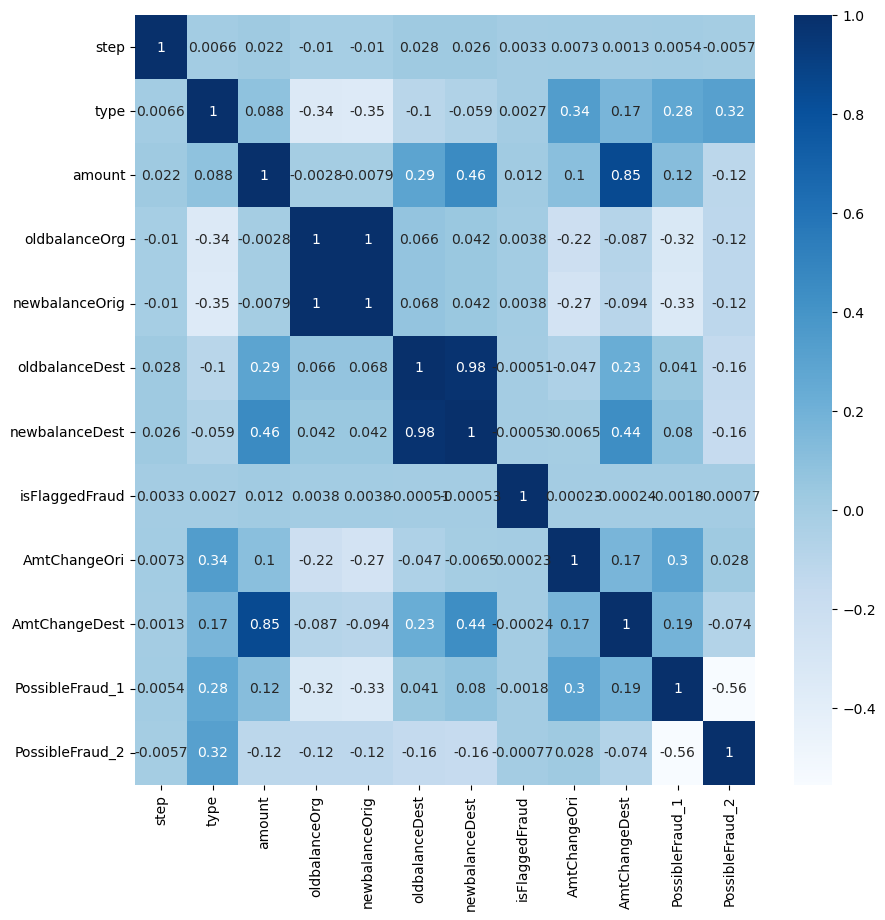

In [33]:
plt.figure(figsize=(10,10))
sns.heatmap(data = scaled_X.corr(), cmap='Blues', annot=True)
plt.show()

#### We can see that oldbalanceOrg and newbalanceOrig + oldbalanceDest and newbalanceDest are highly correlated. Hence we eliminate any one of the two columns in each pair. We also drop AmtChangeDest, since fraud is happening at the Origin account.¶

In [34]:
scaled_X = scaled_X.drop(['oldbalanceOrg','oldbalanceDest'],axis=1)

### After training the model and evaluating it, the precision score was low and hence after checking feature importance, features with lowest importance were dropped and the model was trained and tested again. For this purpose we create X2 here. 
### X2 is responsible for the final model performance.

In [35]:
X2 = scaled_X.copy()

In [36]:
X2 = X2.drop(['newbalanceOrig','PossibleFraud_2', 'AmtChangeDest'], axis =1 )

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size= 0.20, stratify=y)

In [38]:
X_train.shape, y_train.shape

((5090096, 7), (5090096,))

In [39]:
X_test.shape, y_test.shape

((1272524, 7), (1272524,))

### 4.4. Oversampling of minority class

In [40]:
print("Before OverSampling, counts of label '1':{} ".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


Before OverSampling, counts of label '1':6570 
Before OverSampling, counts of label '0': 5083526 

After OverSampling, the shape of train_X: (10167052, 7)
After OverSampling, the shape of train_y: (10167052,) 

After OverSampling, counts of label '1': 5083526
After OverSampling, counts of label '0': 5083526


# 5. Model Training:

In [41]:
dt_model = DecisionTreeClassifier()

In [42]:
dt_model.fit(X_train_res, y_train_res)

DecisionTreeClassifier()

# 6. Model Testing:

In [43]:
y_pred_dt = dt_model.predict(X_test)

# 7. Model Evaluation:

In [44]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.66      0.96      0.78      1643

    accuracy                           1.00   1272524
   macro avg       0.83      0.98      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524



In [45]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(dt_model,X_train_res,y_train_res,cv=3)

In [46]:
print(cvs)

[0.99943317 0.99943051 0.99946445]


### Important features:

In [47]:
dt_imp_features = dt_model.feature_importances_
dt_imp_features

array([0.07532666, 0.04310234, 0.10480154, 0.06458086, 0.        ,
       0.67724438, 0.03494423])

In [48]:
dt_imp_features = pd.Series(dt_imp_features)
dt_imp_features.index = X_train_res.columns
dt_imp_features.sort_values(ascending=False)

AmtChangeOri       0.677244
amount             0.104802
step               0.075327
newbalanceDest     0.064581
type               0.043102
PossibleFraud_1    0.034944
isFlaggedFraud     0.000000
dtype: float64

#### We can see that the last 4 features do not contribute much and hence we can drop those for making model perfom better and retrain the model by creating X2.

## -------------------------------------------------------The CODE ENDS here!--------------------------------------------

# -------------------------------------------------- Q & A:------------------------------------------------

### 1. Data cleaning including missing values, outliers and multi-collinearity.

### 2. Describe your fraud detection model in elaboration.

### 3. How did you select variables to be included in the model?

### 4. Demonstrate the performance of the model by using best set of tools. 

### 5. What are the key factors that predict fraudulent customer? 

### 6. Do these factors make sense? If yes, How? If not, How not? 

### 7. What kind of prevention should be adopted while company update its infrastructure?

### 8. Assuming these actions have been implemented, how would you determine if they work

# THE END!